In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, utils
from tensorflow.data import Dataset
from tensorflow.keras.losses import CategoricalFocalCrossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef

# ===================== CONFIGURACIÓN =====================
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Parámetros del modelo
IMAGE_SIZE = 512
CHANNELS = 11  # 3 canales RGB + 8 morfométricos
NUM_CLASSES = 4  # Fondo + 3 tipos de remoción
BATCH_SIZE = 4
EPOCHS = 50
LEARNING_RATE = 3e-5

# Rutas (¡AJUSTAR ESTAS!)
DATA_BASE_PATH = "E:/Memoria/CNN/Datasets_Final/dataset_multi"
MODEL_SAVE_PATH = r"E:\Memoria\CNN\Modelos_finales\unetCBAM0203.keras"



In [38]:
# ===================== CARGA DE DATOS =====================
def load_split(base_path, split, means=None, stds=None):
    """Carga un split completo (train/val/test)"""
    images_dir = os.path.join(base_path, split, "images")
    masks_dir = os.path.join(base_path, split, "masks")
    
    # Cargar y ordenar archivos
    image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.npy')])
    mask_files = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith('.npy')])
    
    # Cargar datos
    images = np.array([np.load(f) for f in image_files], dtype=np.float32)  # Convertir a float32
    masks = np.array([np.load(f) for f in mask_files])
    
    # Normalización usando estadísticas del train
    if means is not None and stds is not None:
        images = (images - means) / stds
    
    # One-hot encoding para máscaras
    masks = tf.one_hot(masks.astype(np.int32), depth=NUM_CLASSES).numpy()
    
    return images, masks

# Cargar primero el train para calcular estadísticas
X_train, y_train = load_split(DATA_BASE_PATH, "train")
train_means = np.mean(X_train, axis=(0,1,2))
train_stds = np.std(X_train, axis=(0,1,2))

# Recargar todos los splits con normalización consistente
X_train, y_train = load_split(DATA_BASE_PATH, "train", train_means, train_stds)
X_val, y_val = load_split(DATA_BASE_PATH, "val", train_means, train_stds)
X_test, y_test = load_split(DATA_BASE_PATH, "test", train_means, train_stds)



In [39]:
# ===================== CÁLCULO DE PESOS =====================
def calculate_class_weights(masks):
    class_counts = np.zeros(NUM_CLASSES)
    for mask in masks:
        cls, counts = np.unique(np.argmax(mask, axis=-1), return_counts=True)
        for c, cnt in zip(cls, counts):
            class_counts[c] += cnt
    
    # Suavizado para evitar divisiones por cero
    class_counts = np.where(class_counts == 0, 1e-6, class_counts)
    
    # Fórmula balanceada
    weights = 1.0 / (class_counts / np.sum(class_counts))
    return weights / np.sum(weights)  # Normalizar

class_weights = calculate_class_weights(y_train)
print("Pesos calculados:", class_weights)



Pesos calculados: [0.00458703 0.27324145 0.52329437 0.19887715]


In [40]:
# ===================== FUNCIÓN DE PÉRDIDA =====================
class WeightedFocalLoss(CategoricalFocalCrossentropy):
    def __init__(self, alpha, gamma=2.0, name='weighted_focal_loss'):
        super().__init__(alpha=alpha, gamma=gamma, name=name)
        
    def call(self, y_true, y_pred):
        return super().call(y_true, y_pred)


In [41]:
# ===================== AUMENTO DE DATOS =====================
def augment_data(image, mask):
    # Flip aleatorio
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    
    # Rotación de 90° (alternativa sin tensorflow_addons)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)  # Número de rotaciones de 90°
    image = tf.image.rot90(image, k=k)
    mask = tf.image.rot90(mask, k=k)
    
    # Ajuste de brillo solo para canales RGB
    if tf.random.uniform(()) > 0.5:
        rgb_channels = image[..., :3] * tf.random.uniform([], 0.9, 1.1, dtype=image.dtype)
        image = tf.concat([rgb_channels, image[..., 3:]], axis=-1)
    
    return image, mask

In [42]:
# ===================== ARQUITECTURA CBAM-UNET =====================
def cbam_block(inputs, reduction_ratio=8):
    # Channel attention
    channel = layers.GlobalAveragePooling2D()(inputs)
    channel = layers.Dense(inputs.shape[-1]//reduction_ratio, activation='relu')(channel)
    channel = layers.Dense(inputs.shape[-1], activation='sigmoid')(channel)
    channel = layers.Reshape((1, 1, inputs.shape[-1]))(channel)
    
    # Spatial attention
    spatial = layers.Concatenate(axis=-1)([
        layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(inputs),
        layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(inputs)
    ])
    spatial = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(spatial)
    
    return layers.Multiply()([layers.Multiply()([inputs, channel]), spatial])

def build_model():
    inputs = layers.Input((IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    
    # Downsample Path
    # Bloque 1 (512x512 -> 256x256)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = cbam_block(x)
    p1 = layers.MaxPooling2D()(x)  # Salida: 256x256
    
    # Bloque 2 (256x256 -> 128x128)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(p1)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = cbam_block(x)
    p2 = layers.MaxPooling2D()(x)  # Salida: 128x128
    
    # Bottleneck (128x128)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(p2)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = cbam_block(x)
    
    # Upsample Path
    # Bloque 3 (128x128 -> 256x256)
    x = layers.UpSampling2D()(x)  # Upsampling a 256x256
    x = layers.concatenate([x, p1])  # Concatenar con p1 (256x256)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    
    # Bloque 4 (256x256 -> 512x512)
    x = layers.UpSampling2D()(x)  # Upsampling a 512x512
    x = layers.concatenate([x, inputs])  # Concatenar con el input original (512x512)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    
    outputs = layers.Conv2D(NUM_CLASSES, 1, activation='softmax', dtype='float32')(x)
    
    return Model(inputs, outputs)


In [43]:
model = build_model()
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 512, 512,  │      6,400 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 512, 512,  │     36,928 │ conv2d_65[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_66[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 8)         │        520 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 64)        │        576 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_30 (Lambda)  │ (None, 512, 512,  │          0 │ conv2d_66[0][0]   │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_31 (Lambda)  │ (None, 512, 512,  │          0 │ conv2d_66[0][0]   │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_15          │ (None, 1, 1, 64)  │          0 │ dense_31[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_24      │ (None, 512, 512,  │          0 │ lambda_30[0][0],  │
│ (Concatenate)       │ 2)                │            │ lambda_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_31         │ (None, 512, 512,  │          0 │ conv2d_66[0][0],  │
│ (Multiply)          │ 64)               │            │ reshape_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 512, 512,  │         99 │ concatenate_24[0… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_30         │ (None, 512, 512,  │          0 │ multiply_31[0][0… │
│ (Multiply)          │ 64)               │            │ conv2d_67[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 256, 256,  │          0 │ multiply_30[0][0] │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 256, 256,  │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 256, 256,  │    147,584 │ conv2d_68[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_69[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,805,989 (6.89 MB)

 Trainable params: 1,805,989 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:

# ===================== ENTRENAMIENTO =====================
# Preparar datasets
train_dataset = Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(augment_data).shuffle(100).batch(BATCH_SIZE).prefetch(2)

val_dataset = Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

# Construir y compilar modelo
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=WeightedFocalLoss(alpha=class_weights),
    metrics=[
        tf.keras.metrics.OneHotMeanIoU(num_classes=NUM_CLASSES, name='iou'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_iou',
        patience=20,
        mode='max',
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        MODEL_SAVE_PATH,
        save_best_only=True,
        monitor='val_iou',
        mode='max'
    ),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Entrenamiento
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - iou: 0.0397 - loss: 0.0131 - precision: 0.0000e+00 - recall: 0.0000e+00

8/8 ━━━━━━━━━━━━━━━━━━━━ 79s 9s/step - iou: 0.0395 - loss: 0.0133 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_iou: 0.0345 - val_loss: 0.0128 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.0444 - loss: 0.0143 - precision: 0.0000e+00 - recall: 0.0000e+00

8/8 ━━━━━━━━━━━━━━━━━━━━ 71s 9s/step - iou: 0.0444 - loss: 0.0143 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_iou: 0.0396 - val_loss: 0.0127 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.0495 - loss: 0.0151 - precision: 0.0000e+00 - recall: 0.0000e+00

8/8 ━━━━━━━━━━━━━━━━━━━━ 71s 9s/step - iou: 0.0498 - loss: 0.0150 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_iou: 0.0474 - val_loss: 0.0126 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.0668 - loss: 0.0148 - precision: 0.0000e+00 - recall: 0.0000e+00

8/8 ━━━━━━━━━━━━━━━━━━━━ 74s 9s/step - iou: 0.0665 - loss: 0.0146 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_iou: 0.0539 - val_loss: 0.0125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.0738 - loss: 0.0127 - precision: 0.0216 - recall: 5.2793e-08  

8/8 ━━━━━━━━━━━━━━━━━━━━ 73s 9s/step - iou: 0.0742 - loss: 0.0128 - precision: 0.0245 - recall: 6.1055e-08 - val_iou: 0.0623 - val_loss: 0.0124 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.0871 - loss: 0.0108 - precision: 0.1591 - recall: 5.3644e-07

8/8 ━━━━━━━━━━━━━━━━━━━━ 70s 9s/step - iou: 0.0874 - loss: 0.0110 - precision: 0.1768 - recall: 5.7574e-07 - val_iou: 0.0694 - val_loss: 0.0123 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.0980 - loss: 0.0130 - precision: 0.3189 - recall: 1.2772e-06

8/8 ━━━━━━━━━━━━━━━━━━━━ 74s 9s/step - iou: 0.0981 - loss: 0.0130 - precision: 0.3368 - recall: 1.3049e-06 - val_iou: 0.0713 - val_loss: 0.0123 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 71s 9s/step - iou: 0.1029 - loss: 0.0132 - precision: 0.4915 - recall: 3.8493e-06 - val_iou: 0.0712 - val_loss: 0.0122 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.1001 - loss: 0.0113 - precision: 0.8412 - recall: 1.7117e-05

8/8 ━━━━━━━━━━━━━━━━━━━━ 73s 9s/step - iou: 0.1008 - loss: 0.0114 - precision: 0.8374 - recall: 1.6571e-05 - val_iou: 0.0733 - val_loss: 0.0121 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.1085 - loss: 0.0133 - precision: 0.6143 - recall: 1.7165e-05

8/8 ━━━━━━━━━━━━━━━━━━━━ 73s 9s/step - iou: 0.1087 - loss: 0.0132 - precision: 0.6413 - recall: 1.9836e-05 - val_iou: 0.0742 - val_loss: 0.0119 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.1099 - loss: 0.0112 - precision: 0.5924 - recall: 4.2914e-05

8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 10s/step - iou: 0.1103 - loss: 0.0112 - precision: 0.6242 - recall: 4.8488e-05 - val_iou: 0.0755 - val_loss: 0.0119 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.1201 - loss: 0.0111 - precision: 0.8866 - recall: 2.9600e-04

8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 10s/step - iou: 0.1198 - loss: 0.0111 - precision: 0.8764 - recall: 2.7973e-04 - val_iou: 0.0760 - val_loss: 0.0118 - val_precision: 0.0494 - val_recall: 3.8147e-06
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 74s 9s/step - iou: 0.1174 - loss: 0.0115 - precision: 0.7380 - recall: 4.2842e-04 - val_iou: 0.0744 - val_loss: 0.0118 - val_precision: 0.0269 - val_recall: 2.4649e-05
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 9s/step - iou: 0.1232 - loss: 0.0114 - precision: 0.5611 - recall: 0.0010 - val_iou: 0.0751 - val_loss: 0.0117 - val_precision: 0.0256 - val_recall: 8.6858e-05
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 9s/step - iou: 0.1221 - loss: 0.0105 - precision: 0.3799 - recall: 0.0015 - val_iou: 0.0755 - val_loss: 0.0117 - val_precision: 0.0381 - val_recall: 3.5565e-04
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.1167 - loss: 0.0108 - precision: 0.2630 - recall: 0.0026

8/8 ━━━━━━━━━━━━━━━━━━━━ 77s 10s/step - iou: 0.1170 - loss: 0.0108 - precision: 0.2770 - recall: 0.0028 - val_iou: 0.0782 - val_loss: 0.0116 - val_precision: 0.0611 - val_recall: 0.0012
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.1255 - loss: 0.0112 - precision: 0.4036 - recall: 0.0087

8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 10s/step - iou: 0.1254 - loss: 0.0111 - precision: 0.4116 - recall: 0.0088 - val_iou: 0.0834 - val_loss: 0.0113 - val_precision: 0.1356 - val_recall: 0.0037
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 75s 9s/step - iou: 0.1200 - loss: 0.0100 - precision: 0.4791 - recall: 0.0174 - val_iou: 0.0817 - val_loss: 0.0116 - val_precision: 0.1163 - val_recall: 0.0076
Epoch 19/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.1115 - loss: 0.0087 - precision: 0.4370 - recall: 0.0301

8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 10s/step - iou: 0.1135 - loss: 0.0088 - precision: 0.4452 - recall: 0.0309 - val_iou: 0.0838 - val_loss: 0.0115 - val_precision: 0.1584 - val_recall: 0.0147
Epoch 20/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 77s 10s/step - iou: 0.1192 - loss: 0.0100 - precision: 0.4514 - recall: 0.0465 - val_iou: 0.0837 - val_loss: 0.0112 - val_precision: 0.1783 - val_recall: 0.0226
Epoch 21/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.1265 - loss: 0.0092 - precision: 0.5042 - recall: 0.0709

8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 9s/step - iou: 0.1267 - loss: 0.0092 - precision: 0.5059 - recall: 0.0710 - val_iou: 0.0847 - val_loss: 0.0111 - val_precision: 0.2071 - val_recall: 0.0332
Epoch 22/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.1390 - loss: 0.0092 - precision: 0.5934 - recall: 0.0981

8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 10s/step - iou: 0.1381 - loss: 0.0092 - precision: 0.5849 - recall: 0.0978 - val_iou: 0.0870 - val_loss: 0.0113 - val_precision: 0.2259 - val_recall: 0.0473
Epoch 23/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 74s 9s/step - iou: 0.1339 - loss: 0.0100 - precision: 0.5239 - recall: 0.1266 - val_iou: 0.0865 - val_loss: 0.0113 - val_precision: 0.2409 - val_recall: 0.0568
Epoch 24/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.1355 - loss: 0.0089 - precision: 0.4723 - recall: 0.1112

8/8 ━━━━━━━━━━━━━━━━━━━━ 77s 10s/step - iou: 0.1355 - loss: 0.0089 - precision: 0.4789 - recall: 0.1141 - val_iou: 0.0905 - val_loss: 0.0113 - val_precision: 0.2753 - val_recall: 0.0725
Epoch 25/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 9s/step - iou: 0.1295 - loss: 0.0091 - precision: 0.5005 - recall: 0.1374 - val_iou: 0.0881 - val_loss: 0.0114 - val_precision: 0.2626 - val_recall: 0.0764
Epoch 26/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.1358 - loss: 0.0081 - precision: 0.5892 - recall: 0.1810

8/8 ━━━━━━━━━━━━━━━━━━━━ 74s 9s/step - iou: 0.1363 - loss: 0.0082 - precision: 0.5857 - recall: 0.1795 - val_iou: 0.0942 - val_loss: 0.0106 - val_precision: 0.3468 - val_recall: 0.0900
Epoch 27/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 74s 9s/step - iou: 0.1536 - loss: 0.0079 - precision: 0.6144 - recall: 0.1966 - val_iou: 0.0863 - val_loss: 0.0106 - val_precision: 0.2745 - val_recall: 0.0791
Epoch 28/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 70s 9s/step - iou: 0.1397 - loss: 0.0091 - precision: 0.4978 - recall: 0.1604 - val_iou: 0.0855 - val_loss: 0.0109 - val_precision: 0.2575 - val_recall: 0.0819
Epoch 29/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.1308 - loss: 0.0078 - precision: 0.4857 - recall: 0.1756

8/8 ━━━━━━━━━━━━━━━━━━━━ 78s 10s/step - iou: 0.1318 - loss: 0.0078 - precision: 0.4904 - recall: 0.1769 - val_iou: 0.0972 - val_loss: 0.0105 - val_precision: 0.3779 - val_recall: 0.1084
Epoch 30/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 9s/step - iou: 0.1598 - loss: 0.0075 - precision: 0.6029 - recall: 0.2193 - val_iou: 0.0940 - val_loss: 0.0108 - val_precision: 0.3190 - val_recall: 0.1023
Epoch 31/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.1348 - loss: 0.0069 - precision: 0.5277 - recall: 0.1976

8/8 ━━━━━━━━━━━━━━━━━━━━ 75s 9s/step - iou: 0.1367 - loss: 0.0070 - precision: 0.5312 - recall: 0.1999 - val_iou: 0.0979 - val_loss: 0.0111 - val_precision: 0.3296 - val_recall: 0.1109
Epoch 32/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 9s/step - iou: 0.1362 - loss: 0.0076 - precision: 0.5001 - recall: 0.1983 - val_iou: 0.0829 - val_loss: 0.0108 - val_precision: 0.2442 - val_recall: 0.0831
Epoch 33/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 75s 9s/step - iou: 0.1221 - loss: 0.0085 - precision: 0.3894 - recall: 0.1504 - val_iou: 0.0829 - val_loss: 0.0101 - val_precision: 0.2716 - val_recall: 0.0861
Epoch 34/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 9s/step - iou: 0.1325 - loss: 0.0079 - precision: 0.4875 - recall: 0.1801 - val_iou: 0.0922 - val_loss: 0.0101 - val_precision: 0.3458 - val_recall: 0.1073
Epoch 35/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.1534 - loss: 0.0074 - precision: 0.5941 - recall: 0.2437

8/8 ━━━━━━━━━━━━━━━━━━━━ 78s 10s/step - iou: 0.1529 - loss: 0.0075 - precision: 0.5885 - recall: 0.2410 - val_iou: 0.1005 - val_loss: 0.0110 - val_precision: 0.3478 - val_recall: 0.1234
Epoch 36/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 71s 9s/step - iou: 0.1469 - loss: 0.0077 - precision: 0.5260 - recall: 0.2120 - val_iou: 0.0976 - val_loss: 0.0106 - val_precision: 0.3441 - val_recall: 0.1187
Epoch 37/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 74s 9s/step - iou: 0.1571 - loss: 0.0084 - precision: 0.5280 - recall: 0.2036 - val_iou: 0.0908 - val_loss: 0.0108 - val_precision: 0.2749 - val_recall: 0.1041
Epoch 38/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 71s 9s/step - iou: 0.1415 - loss: 0.0072 - precision: 0.5004 - recall: 0.2201 - val_iou: 0.0917 - val_loss: 0.0104 - val_precision: 0.3154 - val_recall: 0.1136
Epoch 39/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.1381 - loss: 0.0073 - precision: 0.4985 - recall: 0.2099

8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 10s/step - iou: 0.1394 - loss: 0.0073 - precision: 0.5031 - recall: 0.2120 - val_iou: 0.1013 - val_loss: 0.0100 - val_precision: 0.3929 - val_recall: 0.1312
Epoch 40/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 9s/step - iou: 0.1682 - loss: 0.0067 - precision: 0.6211 - recall: 0.2778 - val_iou: 0.0977 - val_loss: 0.0104 - val_precision: 0.3575 - val_recall: 0.1257
Epoch 41/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 71s 9s/step - iou: 0.1590 - loss: 0.0066 - precision: 0.5540 - recall: 0.2473 - val_iou: 0.0984 - val_loss: 0.0107 - val_precision: 0.3291 - val_recall: 0.1207
Epoch 42/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 73s 9s/step - iou: 0.1397 - loss: 0.0061 - precision: 0.5170 - recall: 0.2218 - val_iou: 0.0979 - val_loss: 0.0103 - val_precision: 0.3614 - val_recall: 0.1268
Epoch 43/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 9s/step - iou: 0.1545 - loss: 0.0066 - precision: 0.5578 - recall: 0.2365 - val_iou: 0.0968 - val_loss: 0.0105 - val_precision: 0.3374 - val_recall: 0.1232
Epoch 44/50
8/8 ━━━━━━━━━━

8/8 ━━━━━━━━━━━━━━━━━━━━ 78s 10s/step - iou: 0.1430 - loss: 0.0065 - precision: 0.5305 - recall: 0.2252 - val_iou: 0.1025 - val_loss: 0.0103 - val_precision: 0.3663 - val_recall: 0.1339
Epoch 47/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 71s 9s/step - iou: 0.1617 - loss: 0.0064 - precision: 0.5666 - recall: 0.2416 - val_iou: 0.0888 - val_loss: 0.0113 - val_precision: 0.2347 - val_recall: 0.1012
Epoch 48/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 9s/step - iou: 0.1427 - loss: 0.0069 - precision: 0.4369 - recall: 0.2075 - val_iou: 0.0955 - val_loss: 0.0105 - val_precision: 0.3013 - val_recall: 0.1166
Epoch 49/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.1456 - loss: 0.0063 - precision: 0.5550 - recall: 0.2400

8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 10s/step - iou: 0.1463 - loss: 0.0063 - precision: 0.5509 - recall: 0.2391 - val_iou: 0.1054 - val_loss: 0.0101 - val_precision: 0.3785 - val_recall: 0.1377
Epoch 50/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - iou: 0.1656 - loss: 0.0065 - precision: 0.5927 - recall: 0.2742

8/8 ━━━━━━━━━━━━━━━━━━━━ 71s 9s/step - iou: 0.1654 - loss: 0.0065 - precision: 0.5898 - recall: 0.2725 - val_iou: 0.1070 - val_loss: 0.0102 - val_precision: 0.3706 - val_recall: 0.1394


In [45]:
# ===================== EVALUACIÓN =====================
# Evaluar en test
test_results = model.evaluate(test_dataset)
print("\nResultados en Test:")
print(f"Loss: {test_results[0]:.4f}")
print(f"IoU: {test_results[1]:.4f}")
print(f"Precision: {test_results[2]:.4f}")
print(f"Recall: {test_results[3]:.4f}")

# Generar reporte completo
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=-1).flatten()
y_pred = np.argmax(y_pred, axis=-1).flatten()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Fondo', 'Remoción 1', 'Remoción 2', 'Remoción 3']))

print("\nMatthews Correlation Coefficient:", matthews_corrcoef(y_true, y_pred))

# Visualización (opcional)
# visualize_predictions(X_test, y_test, model)  # Implementar según necesidad

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - iou: 0.1238 - loss: 0.0186 - precision: 0.4202 - recall: 0.1868

Resultados en Test:
Loss: 0.0151
IoU: 0.1340
Precision: 0.4628
Recall: 0.2041
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step

Classification Report:
              precision    recall  f1-score   support

       Fondo       0.96      0.42      0.59   4631647
  Remoción 1       0.03      0.44      0.06    124412
  Remoción 2       0.02      0.65      0.04     16164
  Remoción 3       0.08      0.30      0.13    208513

    accuracy                           0.42   4980736
   macro avg       0.27      0.45      0.20   4980736
weighted avg       0.90      0.42      0.55   4980736


Matthews Correlation Coefficient: 0.07789784834420557


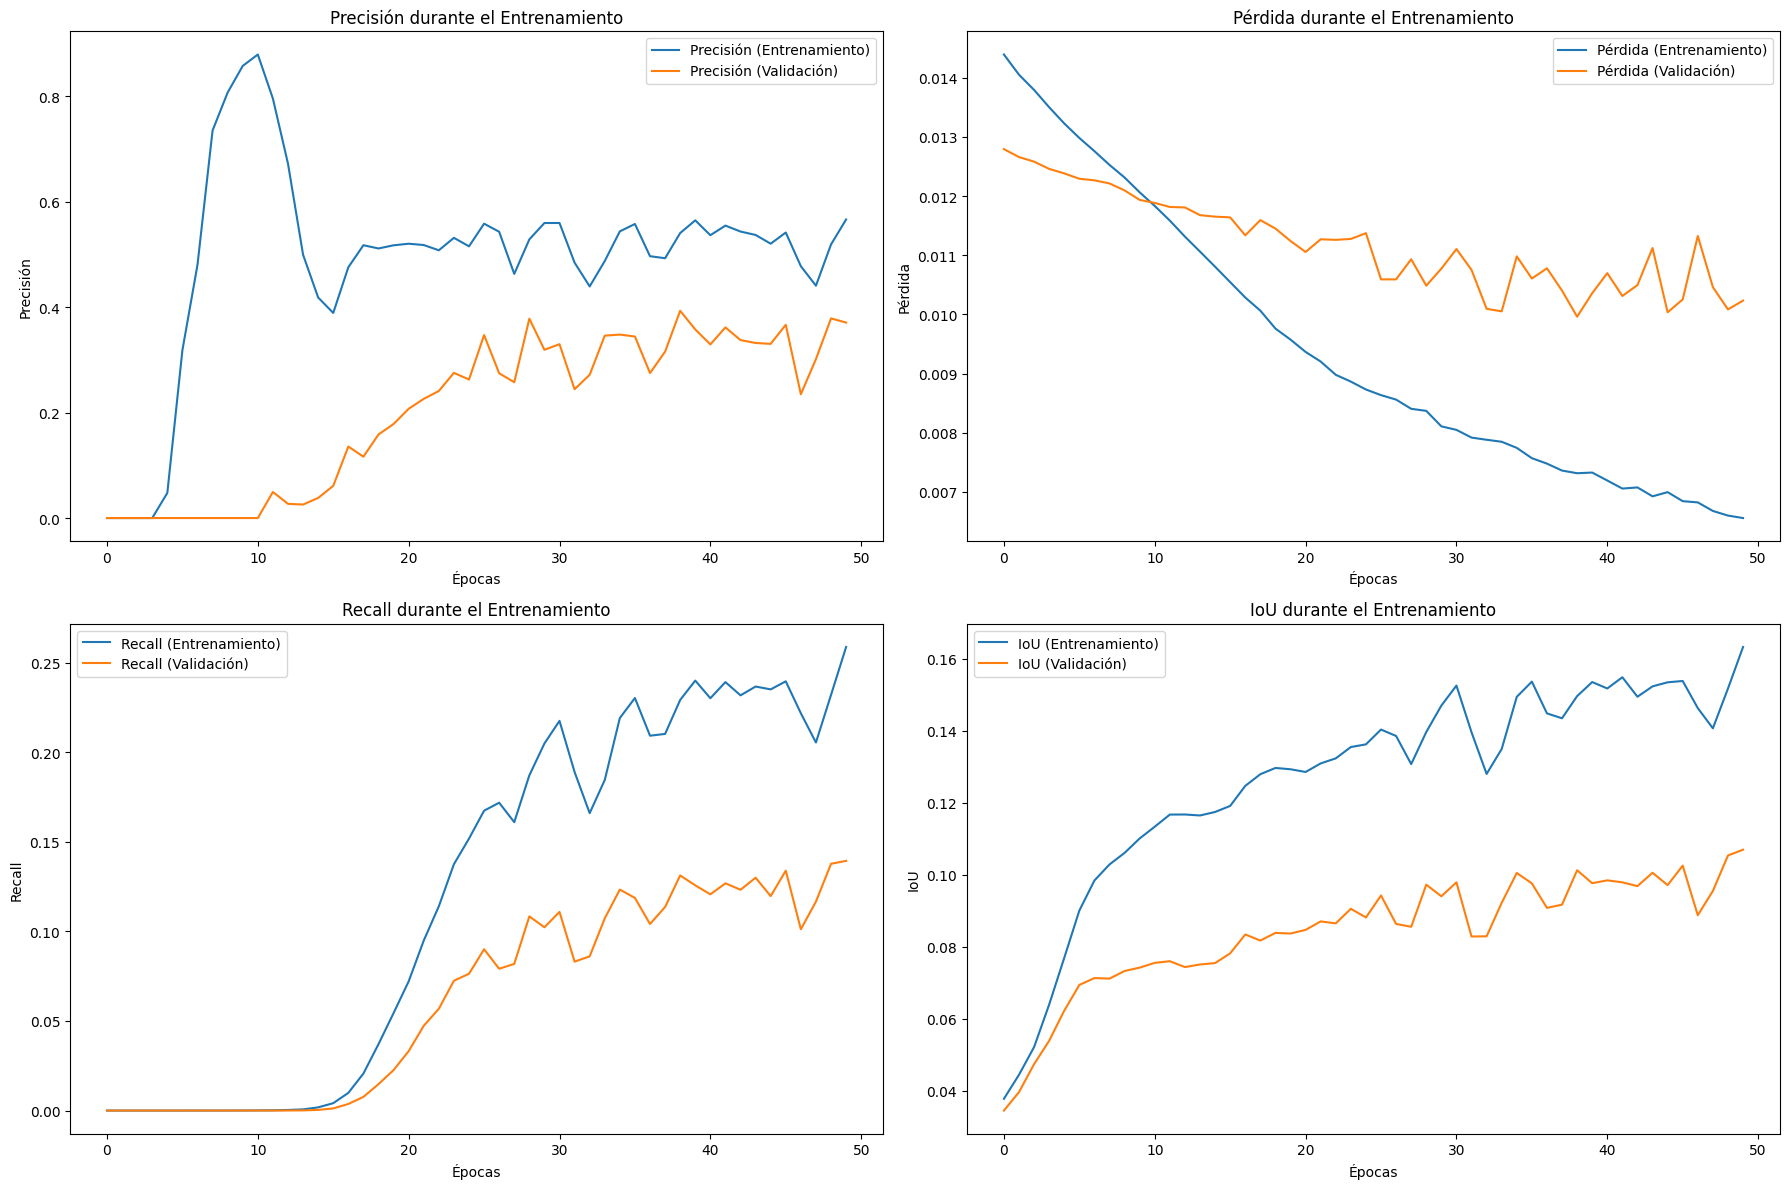

In [54]:
def plot_training_history(history):
    """
    Grafica la precisión y la pérdida durante el entrenamiento y la validación.
    
    Args:
        history: Objeto devuelto por model.fit(), que contiene las métricas de entrenamiento.
    """
    # Obtener las métricas del historial
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_precision = history.history['precision']
    val_precision = history.history['val_precision']
    train_recall = history.history['recall']
    val_recall = history.history['val_recall']
    train_iou = history.history['iou']
    val_iou = history.history['val_iou']
    
    # Crear una figura con subplots
    plt.figure(figsize=(18, 12))
    
    # Gráfico de Precisión
    plt.subplot(2, 2, 1)
    plt.plot(train_precision, label='Precisión (Entrenamiento)')
    plt.plot(val_precision, label='Precisión (Validación)')
    plt.title('Precisión durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    
    # Gráfico de Pérdida
    plt.subplot(2, 2, 2)
    plt.plot(train_loss, label='Pérdida (Entrenamiento)')
    plt.plot(val_loss, label='Pérdida (Validación)')
    plt.title('Pérdida durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    
    # Gráfico de Recall
    plt.subplot(2, 2, 3)
    plt.plot(train_recall, label='Recall (Entrenamiento)')
    plt.plot(val_recall, label='Recall (Validación)')
    plt.title('Recall durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Recall')
    plt.legend()
    
    # Gráfico de IoU
    plt.subplot(2, 2, 4)
    plt.plot(train_iou, label='IoU (Entrenamiento)')
    plt.plot(val_iou, label='IoU (Validación)')
    plt.title('IoU durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('IoU')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
# Graficar el comportamiento del entrenamiento
plot_training_history(history)

In [48]:
def visualize_predictions(model, X_test, y_test, num_samples=3):
    """
    Visualiza las predicciones del modelo junto con las máscaras verdaderas.
    
    Args:
        model: Modelo entrenado.
        X_test: Conjunto de imágenes de prueba.
        y_test: Máscaras verdaderas (en formato one-hot).
        num_samples: Número de muestras a visualizar.
    """
    # Seleccionar muestras aleatorias
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    for idx in sample_indices:
        # Obtener la imagen, máscara verdadera y predicción
        image = X_test[idx]
        true_mask = y_test[idx]
        pred_mask = model.predict(image[np.newaxis, ...])[0]
        
        # Convertir máscaras one-hot a índices de clase
        true_mask = np.argmax(true_mask, axis=-1)
        pred_mask = np.argmax(pred_mask, axis=-1)
        
        # Mostrar resultados
        plt.figure(figsize=(18, 6))
        
     # Imagen original (primeros 3 canales como RGB)
        plt.subplot(1, 3, 1)
 
     # Extraer los primeros 3 canales (asumiendo que son RGB)
        img_rgb = image[..., :3]

     # Normalizar los valores al rango [0, 255] si están fuera de los límites
        img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())  # Normalizar a [0, 1]
        img_rgb = (img_rgb * 255).astype(np.uint8)  # Escalar a [0, 255]

        plt.imshow(img_rgb)
        plt.title("Imagen Original")
        plt.axis("off")

        # Máscara verdadera
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap="jet", vmin=0, vmax=NUM_CLASSES-1)
        plt.title("Máscara Verdadera")
        plt.axis("off")
        
        # Predicción del modelo
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap="jet", vmin=0, vmax=NUM_CLASSES-1)
        plt.title("Predicción del Modelo")
        plt.axis("off")
        
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


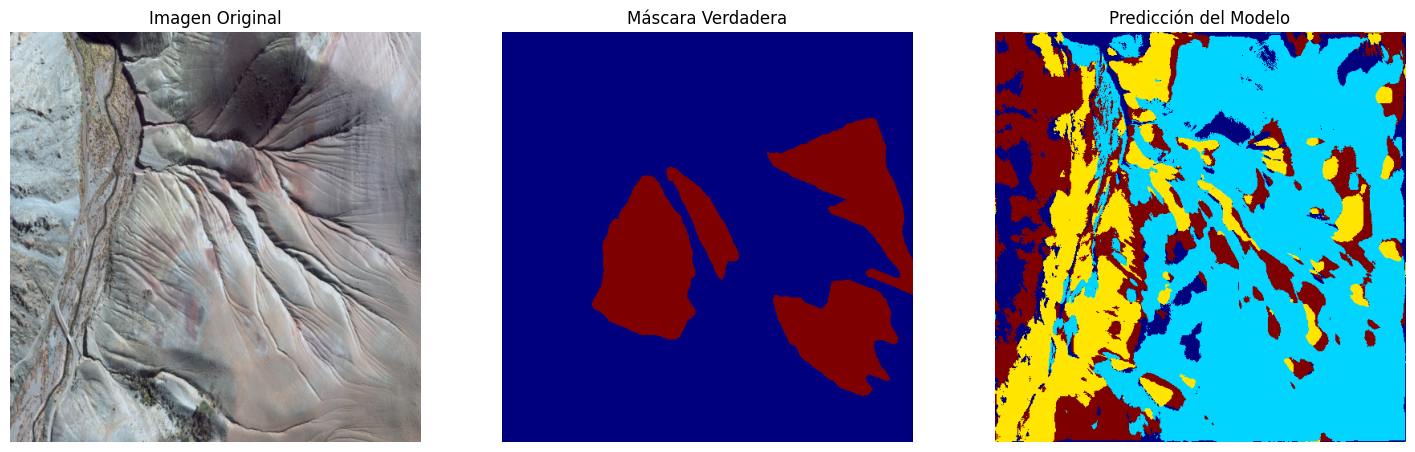

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


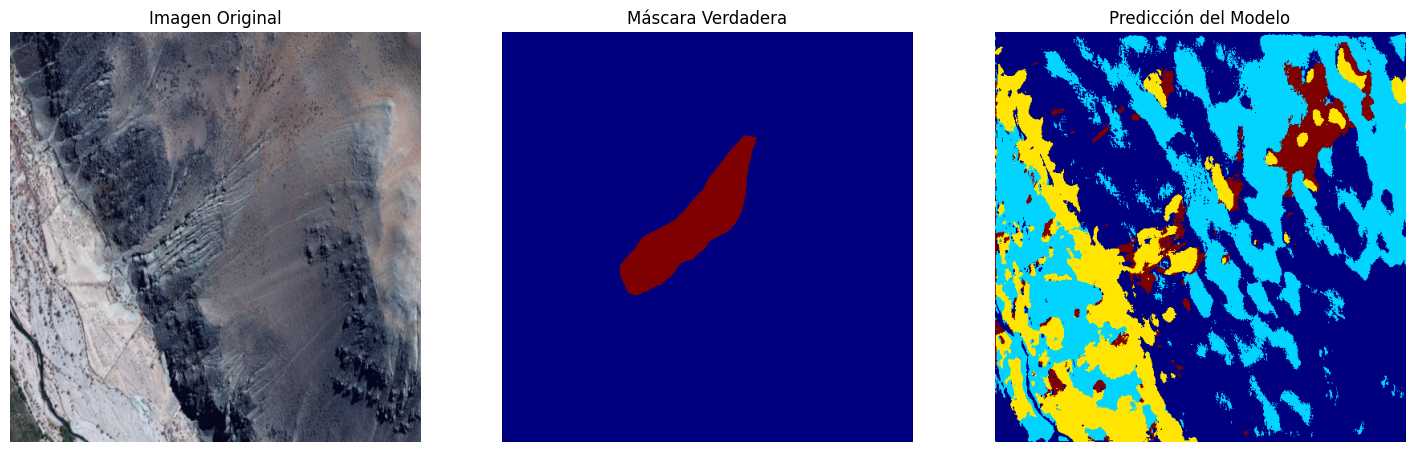

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


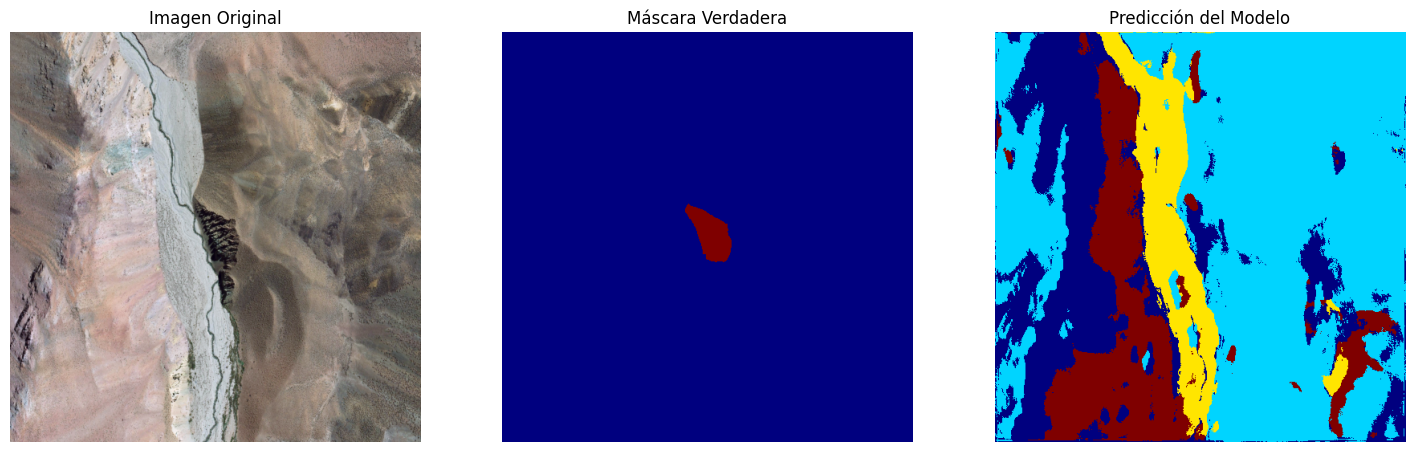

In [52]:

# Visualizar algunas predicciones
visualize_predictions(model, X_test, y_test, num_samples=3)